# Phase Diagram for the Eutectoid System

Here we develop a free energy functional and phase diagram for a system with a peritectoid transition. The idea is that this system is exactly the eutectic system, but below the eutectic temperature an intermediate square phase is stabilized. 

In [2]:
using PyPlot
using Interact
using Maxima
using Optim
using PhaseDiagrams
using Parameters

In [26]:
type Params
    # Mixing stuff
    ϵ₀::Float64
    c₀::Float64
    σ₀::Float64
    ω::Float64
    
    # Ideal stuff
    n0::Float64
    η::Float64
    χ::Float64
   
    # Correlation functions..
end

ex_p = Params(25.0, 0.50, 0.20, 0.1, 0.05, 2.0, 1.0)

Params(25.0,0.5,0.2,0.1,0.05,2.0,1.0)

# Free Energy of the Liquid State

The free energy of the liquid state is very easy to evaluate. It reduces simply to 

$$
\frac{\mathcal{F}_{liq}}{V} = \frac{n_0^2}{2}-\eta\frac{n_0^3}{6} + \chi\frac{n_0^4}{12} + 
(1+n_0)\frac{\Delta\mathcal{F}_{mix}}{V}
$$

In [27]:
function F_mix(σ::Float64, c::Float64, p::Params)
    @unpack ϵ₀, c₀, σ₀, ω, n0 = p
    return ω*((1+n0)*(c*log(c/c₀) + (1-c)*log((1-c)/(1-c₀))) + (-4. + ϵ₀*(σ-σ₀))*(c-c₀)^2/2)
end

function F_mix(σ::Float64, c::Vector{Float64}, p::Params)
    return Float64[F_mix(σ, cᵢ, p) for cᵢ in c]
end

function F_liq(σ::Float64, c::Float64, p::Params) 
    @unpack n0, η, χ = p
    F_ideal =  n0^2/2 - η*n0^3/6 + χ*n0^4/12
    return F_ideal + F_mix(σ, c, p)
end

function F_liq(σ::Float64, c::Array{Float64, 1}, p::Params)
    return Float64[F_liq(σ, cᵢ, p) for cᵢ in c]
end

F_liq (generic function with 3 methods)

Interact.Slider{Float64}(Signal{Float64}(0.2, nactions=0),"σ",0.2,0.0:0.01:0.4,".3f",true)

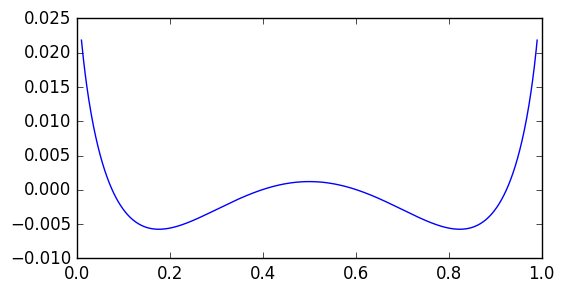

In [28]:
let
    p = Params(10.0, 0.5, 0.30, 0.30, 0.05, 2.0, 1.0)
    f = figure(figsize=(6, 3))
    c = [linspace(0.01, 0.99, 1000)...]
    @manipulate for σ in 0.0:0.01:0.40
        withfig(f) do
            plot(c, F_liq(σ, c, p))
        end
    end
end

# Triangle Ideal Free Energy

This is needed for both the $\beta$ and $\alpha$ phases

In [29]:
f_ideal = m"n^2/2 - η*n^3/6 + χ*n^4/12"

 
                                4      3      2
                               n  χ   n  η   n
                               ---- - ---- + --
                                12     6     2

In [30]:
n = m"n0 + 2*A*n1"            # + A[2]*n2"

f_ideal = subst(n, :n, f_ideal)

 
                          4                  3                  2
             (2 A n1 + n0)  χ   (2 A n1 + n0)  η   (2 A n1 + n0)
             ---------------- - ---------------- + --------------
                    12                 6                 2

In [31]:
f_ideal = expand(f_ideal)

 
    4   4        3      3                            3          4
 4 A  n1  χ   8 A  n0 n1  χ      2   2   2     2 A n0  n1 χ   n0  χ
 ---------- + ------------- + 2 A  n0  n1  χ + ------------ + -----
     3              3                               3          12
      3   3                                    3                              2
   4 A  n1  η      2      2         2        n0  η      2   2               n0
 - ---------- - 2 A  n0 n1  η - A n0  n1 η - ----- + 2 A  n1  + 2 A n0 n1 + ---
       3                                       6                             2

In [32]:
n1 = m"cos(4*%pi/sqrt(3)*(sqrt(3)*x/2 - y/2)) + 
       cos(4*%pi/sqrt(3)*(sqrt(3)*x/2 + y/2)) + 
       cos(4*%pi/sqrt(3)*y)"

f_ideal = subst(n1, :n1, f_ideal);

In [33]:
F_ideal = "integrate(integrate($f_ideal, x, 0, 1), y, 0, sqrt(3)/2)" |> MExpr;

In [34]:
F_ideal = mcall(F_ideal)

 
            3/2       4       7/2      2   2       5/2      3
 ((- ((- 2 3    %pi n0 ) - 8 3    %pi A  n0  - 32 3    %pi A  n0
       7/2      4           3/2       3      7/2      2          5/2      3
 - 20 3    %pi A ) χ) - (4 3    %pi n0  + 8 3    %pi A  n0 + 16 3    %pi A ) η
      5/2       2      7/2      2
 + 4 3    %pi n0  + 8 3    %pi A )/(144 %pi)

In [35]:
F_ideal = ratsimp(F_ideal)
F_ideal = "$F_ideal/(sqrt(3)/2)" |> MExpr |> mcall
F_ideal = ratsimp(F_ideal)
F_ideal = float(F_ideal)
F_ideal = expand(F_ideal)

 
                       4          2   2          3             4
 0.08333333333333333 n0  χ + 3.0 A  n0  χ + 4.0 A  n0 χ + 7.5 A  χ
                                3          2             3           2        2
         - 0.1666666666666667 n0  η - 3.0 A  n0 η - 2.0 A  η + 0.5 n0  + 3.0 A

In [36]:
F_id_exp = parse(F_ideal)                # Make julia expression of the ideal free energy
@eval function F_tri_ideal(A::Float64, p::Params)
    @unpack η, n0, χ = p
    return $F_id_exp
end

F_tri_ideal (generic function with 1 method)

# Square Ideal Free Energy

Ideal free energy for the $\gamma$ solid phase

In [37]:
f_ideal = m"n^2/2 - η*n^3/6 + χ*n^4/12"
n = m"n0 + 2*A1*n1 + 2*A2*n2"
f_ideal = subst(n, :n, f_ideal) |> expand

n1 = m"cos(2*%pi*x) + cos(2*%pi*y)"
n2 = m"cos(%pi*(x + y)) + cos(%pi*(x-y))"
f_ideal = subst(n1, :n1, f_ideal)
f_ideal = subst(n2, :n2, f_ideal);

In [38]:
F_ideal = "integrate(integrate($f_ideal, x, 0, 1), y, 0, 1)" |> MExpr
F_ideal = mcall(F_ideal)

 
           4             2            2    2                2                4
 ((3 %pi n0  + (72 %pi A2  + 72 %pi A1 ) n0  + 288 %pi A1 A2  n0 + 108 %pi A2
             2   2             4                  3
 + 432 %pi A1  A2  + 108 %pi A1 ) χ + ((- 6 %pi n0 )
                2             2                    2               2
 + ((- 72 %pi A2 ) - 72 %pi A1 ) n0 - 144 %pi A1 A2 ) η + 18 %pi n0
            2            2
 + 72 %pi A2  + 72 %pi A1 )/(36 %pi)

In [39]:
F_ideal = F_ideal |> ratsimp |> float |> expand 

 
                       4           2   2           2   2              2
 0.08333333333333333 n0  χ + 2.0 A2  n0  χ + 2.0 A1  n0  χ + 8.0 A1 A2  n0 χ
         4            2   2           4                          3
 + 3.0 A2  χ + 12.0 A1  A2  χ + 3.0 A1  χ - 0.1666666666666667 n0  η
         2              2                 2           2         2         2
 - 2.0 A2  n0 η - 2.0 A1  n0 η - 4.0 A1 A2  η + 0.5 n0  + 2.0 A2  + 2.0 A1

In [40]:
F_id_exp = parse(F_ideal)
@eval function F_sqr_ideal(A1::Float64, A2::Float64, p::Params)
    @unpack η, χ, n0 = p
    return $F_id_exp
end

F_sqr_ideal (generic function with 1 method)

# Excess Free Energy for all Solids
---
## Correlation functions

There are a variety of effective pair correlation functions we can choose from. Here is one of them from the original xpfc paper

In [41]:
# Triangle α phase!
k₁ = 2π
α₁ = 0.8
β₁ = 6.0
ρ₁ = sqrt(3)/2.0

Cα(k, σ) = exp(-σ^2*k₁^2/(2*β₁*ρ₁))*exp(-(k-k₁)^2/(2*α₁^2))

# Triangle β phase
k₂ = 4π/√3
α₂ = 0.8
β₂ = 6.0
ρ₂ = 1.0

Cβ(k, σ) = exp(-σ^2*k₂^2/(2*β₂*ρ₂))*exp(-(k-k₂)^2/(2*α₂^2))

# Square γ phase
k1 = 2π
k2 = √2*π
α1 = 0.7
α2 = 0.7
β1 = 4.0
β2 = 4.0
ρ1 = 1.0
ρ2 = √2/2

Cγ(k, σ) = exp(-σ^2*k1^2/(2*β1*ρ1))*exp(-(k-k1)^2/(2*α1^2)) + exp(-σ^2*k2^2/(2*β2*ρ2))*exp(-(k-k2)^2/(2*α2^2))

# Interpolation functions
X(c) = 1.0 - 3.0*c^2 + 2.0*c^3
Xα(c) = c < 0.5 ? X(2c) : 0.0
Xγ(c) = c < 0.5 ? X(2*(1-c)-1) : X(2c-1)
Xβ(c) = c < 0.5 ? 0.0 : X(2*(1-c))

C_eff(k::Float64, c::Float64, σ::Float64) = Xα(c)*Cα(k, σ) + Xγ(c)*Cγ(k, σ) + Xβ(c)*Cβ(k, σ) 

function find_k(c, T)
    sol = optimize(k -> -C_eff(k, c, T), 2π, 4π/√3)
    k₀ = float(sol.minimum)
    return k₀
end

find_k (generic function with 1 method)

Interact.Slider{Float64}(Signal{Float64}(0.5, nactions=0),"c",0.5,0.0:0.01:1.0,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.5, nactions=0),"T",0.5,0.0:0.01:1.0,".3f",true)

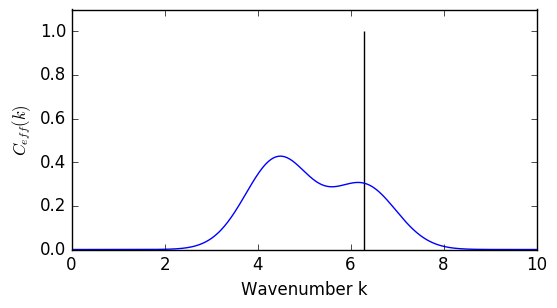

In [42]:
let
    N = 400
    k = linspace(0.0, 10.0, N)
    CC = Array(Float64, N)
    f = figure(figsize=[6, 3])
    @manipulate for c in 0.0:0.01:1.0, T in 0.0:0.01:1.0
        withfig(f) do
            for i in 1:N
                CC[i] = C_eff(k[i], c, T)
            end
            kmax = find_k(c, T)
            plot(k, CC)
            vlines(kmax, 0.0, 1.0)
            xlim(0, 10)
            ylim(0, 1.1)
            xlabel("Wavenumber k")
            ylabel(L"$C_{eff}(k)$")
        end 
    end
end

## Excess Free Energy

The excess free energy term in the binary phase field crystal model is the form

$$
\mathcal{F}_{ex}[n, c] = -\frac{1}{2 V_{cell}}\int_{cell} dr \int dr^\prime n(r) C_{eff}(r, r^\prime; c) n(r^\prime)
$$

Most of the modes in the amplitude expansion cancel out but we're left with the following at the end of the day:

$$
\mathcal{F}_{ex}[n, c] = -\frac{1}{2 V_{cell}}(n_0^2 C_{eff}(k=0, c) + 6 A_1^2 C_{eff}(k=k_1, c) + 6 A_2^2 C_{eff}(k=k_2, c))
$$

In [43]:
function F_ex_α(c, T, A)
    return -3.0*A^2*C_eff(k₁, c, T)
end

function F_ex_β(c, T, A)
    return -3.0*A^2*C_eff(k₂, c, T)
end

function F_ex_γ(c, T, A1, A2)
    return -2.0*A1^2*C_eff(k1, c, T) - 2.0*A2^2*C_eff(k2, c, T)
end

F_ex_γ (generic function with 1 method)

Interact.Slider{Float64}(Signal{Float64}(0.491, nactions=0),"c",0.491,0.001:0.01:0.991,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.25, nactions=0),"T",0.25,0.0:0.01:0.5,".3f",true)

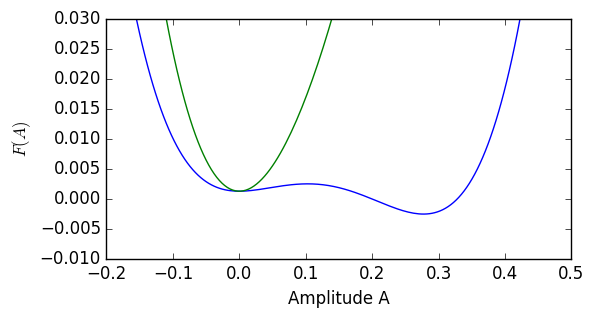

In [44]:
let
    N = 1000
    A = linspace(-2.0, 2.0, N)
    fα = Array(Float64, N)
    fβ = Array(Float64, N)
    fγ = Array(Float64, N)
    f = figure(figsize=(6, 3))
    @manipulate for c in 0.001:0.01:0.999, T in 0.0:0.01:0.5
        withfig(f) do
            for i in 1:N
                fα[i] = F_ex_α(c, T, A[i]) + F_tri_ideal(A[i], ex_p) + F_mix(T, c, ex_p)
                fβ[i] = F_ex_β(c, T, A[i]) + F_tri_ideal(A[i], ex_p) + F_mix(T, c, ex_p)
            end
            plot(A, fα)
            plot(A, fβ)
            ylim(-0.01,0.03)
            xlim(-0.2, 0.5)
            xlabel("Amplitude A")
            ylabel(L"F(A)")
        end
    end
end

## Total free energy

The total free energy is sum of all the above terms

In [45]:
F_α(c, σ, A, p) = F_mix(σ, c, p) + F_tri_ideal(A, p) + F_ex_α(c, σ, A)
F_β(c, σ, A, p) = F_mix(σ, c, p) + F_tri_ideal(A, p) + F_ex_β(c, σ, A)
F_γ(c, σ, A1, A2, p) = F_mix(σ, c, p) + F_sqr_ideal(A1, A2, p) + F_ex_γ(c, σ, A1, A2)

function F_α(c, σ, p)
    if c < 0.3
        sol = optimize(A -> F_α(c, σ, A, p), 0.0, 10.0)
        return sol.f_minimum
    else
        return F_α(c, σ, 0.0, p)
    end
end

function F_β(c, σ, p)
    sol = optimize(A -> F_β(c, σ, A, p), 0.0, 10.0)
    return sol.f_minimum
end

function F_γ(c, σ, p)
    sol = optimize(A -> F_γ(c, σ, A[1], A[2], p), [0.3, 0.3])
    return sol.f_minimum
end

F_α(c, σ) = F_α(c, σ, ex_p)
F_β(c, σ) = F_β(c, σ, ex_p)
F_γ(c, σ) = F_γ(c, σ, ex_p)
F_liq(σ, c) = F_liq(σ, c, ex_p)

F_liq (generic function with 3 methods)

Interact.Slider{Float64}(Signal{Float64}(0.25, nactions=0),"T",0.25,0.0:0.01:0.5,".3f",true)

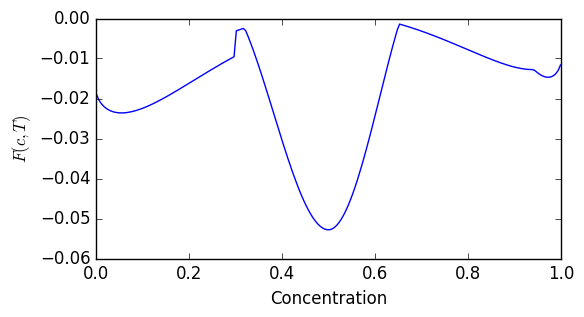

In [25]:
let
    N = 200
    c = linspace(0.001, 0.999, N)
    f_l = Array(Float64, N)
    f_γ = Array(Float64, N)
    f_α = Array(Float64, N)
    f_β = Array(Float64, N)
    f = figure(figsize=[6, 3])
    @manipulate for T in 0.0:0.01:0.5
        withfig(f) do
            for i in 1:N
                f_l[i] = F_liq(T, c[i])
                f_γ[i] = F_γ(c[i], T)
                f_α[i] = F_α(c[i], T)
                f_β[i] = F_β(c[i], T)
            end
            plot(c, min(f_l, f_α, f_β, f_γ))
            #plot(c, f_α)
            #plot(c, f_β)
            #plot(c, f_γ)
            xlim(0, 1)
            xlabel("Concentration")
            ylabel(L"F(c, T)")
        end
    end
end

In [116]:
function make_phase_diagram(crnge, Trnge)
    T_vals = Float64[] 
    c_vals = Float64[]
    
    c = collect(crnge)
    T = collect(Trnge)
    
    f_l = Array(Float64, length(c))
    f_α = Array(Float64, length(c))
    f_β = Array(Float64, length(c))
    f_γ = Array(Float64, length(c))
    f_tot = Array(Float64, length(c))
    
    for t in 1:length(T)
        for i in 1:length(c)
            f_l[i] = F_liq(T[t], c[i])
            f_α[i] = F_α(c[i], T[t])
            f_β[i] = F_β(c[i], T[t])
            f_γ[i] = F_γ(c[i], T[t])
        end
        f_tot[:] = min(f_l, f_α, f_β, f_γ)
        arr = commontangent(f_tot)
        for domain in arr
            for point in domain
                push!(T_vals, T[t])
                push!(c_vals, c[point])
            end
        end
    end
    return T_vals, c_vals
end

make_phase_diagram (generic function with 1 method)

In [117]:
crnge = 0.001:0.01:0.999
Trnge = 0.00:0.005:0.35

T_vals, c_vals = make_phase_diagram(crnge, Trnge)

([0.0,0.0,0.005,0.005,0.01,0.01,0.015,0.015,0.02,0.02  …  0.33,0.33,0.33,0.33,0.335,0.335,0.335,0.335,0.34,0.34],[0.001,0.991,0.001,0.991,0.001,0.991,0.001,0.991,0.001,0.991  …  0.171,0.491,0.501,0.831,0.201,0.491,0.501,0.791,0.381,0.621])

In [25]:
f = figure()
withfig(f) do
    scatter(c_vals, T_vals, c="k")
    grid(false)
    xlim(0, 1)
    ylim(0.00, 0.40)
    xlabel(L"Concentration $(c)$")
    ylabel(L"Temperature $(T)$")
    title("Syntectic Phase Diagram")
end

savefig("Sytectic Phase Diagram.svg")

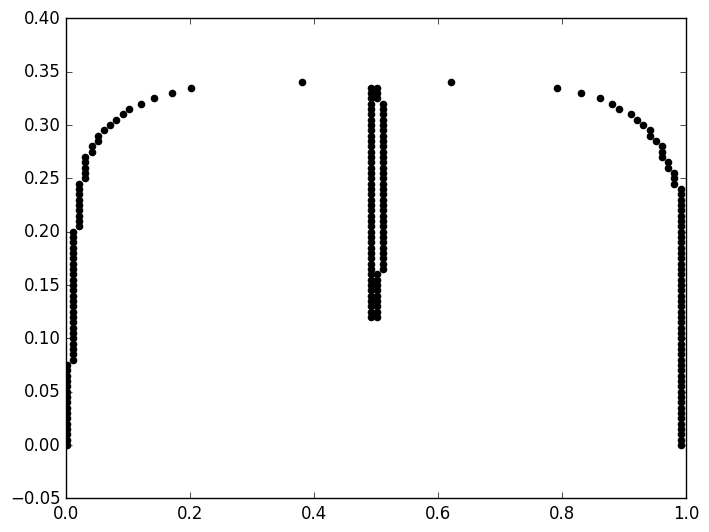

In [118]:
scatter(c_vals, T_vals, c="k")
xlim(0, 1)
grid(false)